Goal: Combine processed DWR Periodic GWL database with local continuous groundwater monitoring data. This dataset will be preprocess for the entire period of record and filtered down to recent time when loaded into the model main code.

In [1]:
import os
from os.path import basename, dirname, exists, join
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime

import matplotlib.pyplot as plt

In [2]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)

git_dir = join(doc_dir, 'GitHub')
py_dir = git_dir +'/CosumnesRiverRecharge/python_utilities/'

gwfm_dir = dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'


In [3]:
hob_dir = gwfm_dir+'/HOB_data'
ghb_dir = gwfm_dir+'/GHB_data'

In [4]:
# Load model grid as geopandas object
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')
m_domain = gpd.read_file(gwfm_dir+'/DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp')

dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_linear.tsv', delimiter = '\t')


In [5]:
# set reasonable range of dates that might be used for Cosumnes modeling work
strt_date = pd.to_datetime('1990-10-01')
end_date = pd.to_datetime(datetime.date.today())


## Load and prepare DWR data
**Notes**
- I downloaded a version in March 2022 to re-run everything but it seems that this was missing quite a few measurements that are available in the April 2023 dataset and were previously available when I first downloaded the data in 2020. Also DWR is the newer versions switched to lower case. DWR added daily measurements to the periodic dataset starting Feb 2023
- Only 1 of the DWR continuous stations is in the domain (McCormack-William track, ND2)
- I think with the SGMA process DWR removed old data based on GSA recommendations so the monthly measurements are missing now for many wells

In [10]:
stations = pd.read_csv(ghb_dir+'/periodic_gwl_bulkdatadownload/stations.csv')
perf = pd.read_csv(ghb_dir+'/periodic_gwl_bulkdatadownload/perforations.csv')
stations = stations.join(perf.set_index('site_code'), how='left', on='site_code')

periodic = pd.read_csv(ghb_dir+'/periodic_gwl_bulkdatadownload/measurements.csv')
stations_gpd = gpd.GeoDataFrame(stations,
                                geometry = gpd.points_from_xy( stations.longitude, stations.latitude), crs = 'epsg:4326')
# need to use the domain in lat, long crs as some wells may edge in utm zone 11n
stations_gpd = gpd.sjoin(stations_gpd.to_crs('epsg:32610'),m_domain, how = 'inner', predicate = 'intersects')
stations_gpd = stations_gpd.drop(columns=['index_right'])
# join the periodic measurements with the site locations 
domain_periodic = periodic.merge(stations_gpd, on = ['site_code'])

domain_periodic['msmt_date']=pd.to_datetime(domain_periodic['msmt_date'])
domain_periodic = domain_periodic.set_index('msmt_date')
# filter to modern time
domain_periodic = domain_periodic.loc[domain_periodic.index>strt_date]

C:\Users\AndrewCalderwood\AppData\Local\Temp\ipykernel_17100\4251942452.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  stations = pd.read_csv(ghb_dir+'/periodic_gwl_bulkdatadownload/stations.csv')
C:\Users\AndrewCalderwood\AppData\Local\Temp\ipykernel_17100\4251942452.py:5: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  periodic = pd.read_csv(ghb_dir+'/periodic_gwl_bulkdatadownload/measurements.csv')


In [11]:

# domain_periodic_2010s = pd.read_csv(hob_dir+'/dwr_gwe_data_2010s.csv', index_col = 'MSMT_DATE', parse_dates =True)
# filter out columns relevant to observation
domain_periodic_adj = domain_periodic[['site_code', 'gwe', 'wlm_rpe','wlm_gse',  'wlm_acc_desc',
                                       'latitude','longitude','well_type','well_use',
                                       'well_depth','top_prf_int', 'bot_prf_int']]

# filter out measurements for the actual modeled period
domain_periodic_adj.index = pd.to_datetime(domain_periodic_adj.index)

dwr_obs = domain_periodic_adj.loc[(domain_periodic.index>strt_date)&(domain_periodic.index<end_date)]
# convert observations to geodataframe to merge with
dwr_obs_gpd = gpd.GeoDataFrame(dwr_obs, geometry = gpd.points_from_xy(dwr_obs.longitude,dwr_obs.latitude))
dwr_obs_gpd.crs = 'epsg:4326'
dwr_obs_gpd = dwr_obs_gpd.to_crs('epsg:32610')
# the grid is a 1 based system
dwr_obs_grid = gpd.sjoin(dwr_obs_gpd,grid_p).drop(columns='index_right')

# convert units from ft to meters
dwr_obs_grid.loc[:,['gwe','wlm_rpe','wlm_gse', 'well_depth','top_prf_int', 'bot_prf_int']] *= 0.3048
dwr_obs_grid = dwr_obs_grid.dropna(subset=['gwe'])
# set data source for filtering
dwr_obs_grid['agency'] = 'DWR'

dwr_obs_grid.to_csv(join(hob_dir, 'dwr_cropped_to_domain.csv'))

## Load and prepare UC Davis continuous data

In [27]:
ucd_meta = pd.read_csv(hob_dir+'/CosumnesRiverPreserve_MW_screened_interval.csv')
# ucd water surface elevation data is in units of meters
ucd_data = pd.read_csv(hob_dir+'/AllSets.csv', index_col='dt',parse_dates=True)
ucd_data = ucd_data.apply(pd.to_numeric, errors='coerce')
ucd_mon = ucd_data.resample('MS').mean(numeric_only=True)

# remove timezone component of date format
ucd_mon.index = ucd_mon.index.tz_localize(tz=None)
# filter out measurements for the actual modeled period
ucd_mon = ucd_mon.loc[strt_date:end_date]
# melt dataframe by id and date
ucd_mon = ucd_mon.reset_index().melt(id_vars = ['dt'], value_vars=ucd_mon.columns)
ucd_mon = ucd_mon.rename({'variable':'Well_ID','value':'wse_m'},axis=1)

# update screened intervals and convert to meters
ucd_meta[['top_prf_int','bot_prf_int']] = 0.3048*ucd_meta['Screened Interval (ft)'].str.split('-',n=2, expand=True).astype(float)
# # calculate elevation from screened interval depth
# ucd_meta['top_prf_int'] = ucd_meta['MPE (meters)'] - ucd_meta.top_screen*0.3048
# ucd_meta['bot_prf_int'] = ucd_meta['MPE (meters)'] - ucd_meta.bot_screen*0.3048


C:\Users\AndrewCalderwood\AppData\Local\Temp\ipykernel_17100\1993905250.py:3: DtypeWarning: Columns (11,14) have mixed types. Specify dtype option on import or set low_memory=False.
  ucd_data = pd.read_csv(hob_dir+'/AllSets.csv', index_col='dt',parse_dates=True)


In [29]:
# convert observations to geodataframe to merge with
ucd_meta_gpd = gpd.GeoDataFrame(ucd_meta, geometry = gpd.points_from_xy(ucd_meta.Longitude,ucd_meta.Latitude))
ucd_meta_gpd.crs = 'epsg:4326'
ucd_meta_gpd = ucd_meta_gpd.to_crs('epsg:32610')
# the grid is a 1 based system
ucd_meta_grid = gpd.sjoin(ucd_meta_gpd,grid_p)

# estimate GSE from RPE
ucd_meta_grid['wlm_gse'] = ucd_meta_grid['MPE (meters)']-1
ucd_meta_grid['well_depth'] = ucd_meta_grid['Well Depth (ft)']*0.3048

# simplify from 22 to 8 wells for now because there will be overfitting of wells at Oneto-Denier and 
# these wells all have LevelSenders allowing for easier data access
ucd_select = ucd_meta_grid.set_index('Well ID').loc[['MW_DR1', 'MW_9', 'MW_11', 'MW_19','MW_5', 'MW_22','MW_Rooney 1']]

In [30]:
# join wse data with location and metadata
ucd_obs = ucd_mon.join(ucd_select, how = 'right',on = 'Well_ID')
ucd_obs = ucd_obs.dropna(subset=['wse_m']) # remove NA values

# prepare UCD obs for joining with DWR obs
ucd_obs = ucd_obs.set_index('dt')[['Well_ID','wse_m','wlm_gse','node','row','column',
                                   'well_depth', 'top_prf_int','bot_prf_int', 'well_use',
                                  'Latitude',"Longitude"]]
ucd_obs = ucd_obs.rename({'Well_ID':'site_code','wse_m':'gwe',
                         'Latitude':'latitude','Longitude':'longitude'},axis=1)
# set data source for filtering
ucd_obs['agency'] = 'UCD'

## Join DWR and UCD data
UCD data is commented out for now

In [ ]:
# dwr_obs_grid = pd.read_csv(join(hob_dir, 'dwr_cropped_to_domain.csv'))

In [32]:
# convert to dataframe and drop
dwr_obs_out = pd.DataFrame(dwr_obs_grid).drop(columns='geometry')
# dwr_obs_out# join UCD and DWR obs
#.loc[:,['site_code','GWE','WLM_GSE','node','row','column', 'agency', 'WELL_DEPTH']],
all_obs = pd.concat((dwr_obs_out, ucd_obs))
# all_obs = dwr_obs_grid.loc[:,['site_code','GWE','WLM_GSE','node','row','column']]

# add name to index
all_obs.index.name='date'

# break all_obs into stations again for some manipulation of constant values (e.g. well depth)
# keep last because generally more relevant than first, drop time changing columns
all_stns = all_obs.drop_duplicates('site_code', keep='last').reset_index().drop(columns=['date','gwe'])

## Adjust observations for elevation

In [33]:
# find DEM elevation and difference between measured and DEM
all_stns['dem_elev'] = dem_data[(all_stns.row-1).values.astype(int),(all_stns.column-1).values.astype(int)]
all_stns['dem_wlm_gse'] = all_stns.dem_elev - all_stns.wlm_gse
# recalculate WSE based on DEM elevation
# all_obs['wse_m_adj'] = all_obs.dem_elev - (all_obs['wlm_gse'] - all_obs.gwe)


24.85 % of the sites have a difference > 1 m


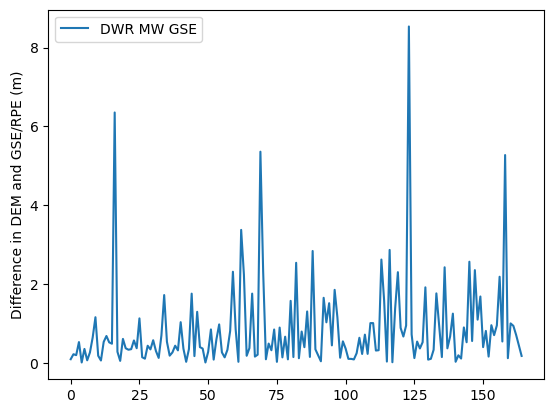

In [34]:
temp = all_stns.dem_wlm_gse.abs()
temp.plot(label = 'DWR MW GSE')
plt.legend()
max_diff = 1
plt.ylabel('Difference in DEM and GSE/RPE (m)')
print('%.2f'%(((temp>max_diff).sum()/temp.shape)[0]*100) ,'% of the sites have a difference >', max_diff,'m' )

## Approximate depth
- 1. Use avg screen elevation
- 2. Use 90% total depth
- 3. Use 90% interpolated depth based on similar well types


In [35]:
ag_well_depth_arr = np.loadtxt(gwfm_dir+'/WEL_data/ag_well_depth_arr.tsv', delimiter='\t')
dom_well_depth_arr= np.loadtxt(gwfm_dir+'/WEL_data/domestic_well_depth_arr.tsv', delimiter='\t')

In [36]:
ag_stns = all_stns[all_stns.well_use.isin(['Irrigation','Stockwatering'])].copy()
ag_stns['interp_depth_m'] = ag_well_depth_arr[ag_stns.row-1, ag_stns.column-1]
dom_stns = all_stns[all_stns.well_use=='Residential'].copy()
dom_stns['interp_depth_m'] = ag_well_depth_arr[dom_stns.row-1, dom_stns.column-1]
interp_obs = pd.concat((ag_stns, dom_stns)).set_index('site_code')[['interp_depth_m']]
# add interpolated depth column
all_stns['interp_depth'] = all_stns.join(interp_obs, on='site_code', how='left')['interp_depth_m']

In [37]:
no_depth = all_stns[(all_stns.well_depth.isna() & all_stns.interp_depth.isna())]
depth_chk = no_depth.shape[0]/all_stns.shape[0]
print('Only %.1f %% have no estimate for depth, safe to remove' %(depth_chk*100))

# remove the subset with no estimate for screened interval
all_stns = all_stns[~all_stns.site_code.isin(no_depth.site_code)]

Only 3.0 % have no estimate for depth, safe to remove


In [38]:
# for HOB, sample the water level from the mean of the top and bottom interval
all_stns['avg_screen_depth'] = (all_stns.top_prf_int+all_stns.bot_prf_int)/2
# if screen interval information is not available then assume screen is at 90-100% depth of well
still_na = all_stns.avg_screen_depth.isna()
all_stns.loc[still_na,'avg_screen_depth'] = all_stns.loc[still_na,'well_depth'] * 0.95

# # if screen interval information is not available then assume screen is at 90-100% depth of well
still_na = all_stns.avg_screen_depth.isna()
all_stns.loc[still_na,'avg_screen_depth'] = all_stns.loc[still_na,'interp_depth'] * 0.95



## Create unique observation names

In [39]:

all_obs['obs_nam'] = all_obs.node.astype(str)
# use the model grid node number to shorten the dwr_site code name
nodes = all_obs.obs_nam.unique()

for i in np.arange(0,len(nodes)):
    # find matching observations to the unique node
    df = all_obs.loc[all_obs.obs_nam==nodes[i]].copy()
    # check ndim for counting number of obs per node
    if df.ndim >1: nobs = len(df)
    else: nobs=1    
    for n in np.arange(0,nobs):
        df.obs_nam.iloc[n] = 'N'+df.obs_nam.iloc[n]+'.'+str(n+1).zfill(5)
#     # reset node name in dwr_obs
    all_obs.loc[all_obs.obs_nam==nodes[i],:] = df.copy()
    

C:\Users\AndrewCalderwood\AppData\Local\Temp\ipykernel_17100\1425808777.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.obs_nam.iloc[n] = 'N'+df.obs_nam.iloc[n]+'.'+str(n+1).zfill(5)
C:\Users\AndrewCalderwood\AppData\Local\Temp\ipykernel_17100\1425808777.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.obs_nam.iloc[n] = 'N'+df.obs_nam.iloc[n]+'.'+str(n+1).zfill(5)
C:\Users\AndrewCalderwood\AppData\Local\Temp\ipykernel_17100\1425808777.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [40]:
# replace well measurement information with udpated info
all_obs_out = all_obs[['site_code','gwe', 'obs_nam']].join(all_stns.set_index('site_code'), on='site_code', how='inner')

## Remove outliers based on rolling std dev

In [41]:
def auto_qaqc(all_obs_out, years):
    """Using the mean and standard deviation of a GWL time series to determine if
    a measurement could be considered an outlier"""
    # do with year start to start at first step
    all_obs_gwe = all_obs_out[['site_code','gwe']].copy()
    # originally developed with 5 year time frame for biannual measurements
    freq=str(years*365)+'D'
#     print(freq)
    # need to use numpy function because pandas function will give na if only one value exists
    gwe_mean = pd.DataFrame(all_obs_gwe.groupby('site_code').rolling(freq, center=False).mean()['gwe']).rename(columns={'gwe':'gwe_mean'})
    gwe_mean['std_dev'] =  all_obs_gwe.groupby('site_code').rolling(freq, center=False).std()['gwe']

    # 2 std deviations removes obs that are safe
    num_std = 3
    # correct if the standard deviation is very large by reducing to 1 std dev
    # 20 m (60 ft) std deviation would be very large for this basin
    gwe_mean.loc[gwe_mean.std_dev>10, 'std_dev'] /=3
    gwe_mean['lower'] = gwe_mean.gwe_mean - gwe_mean.std_dev*num_std
    gwe_mean['upper'] = gwe_mean.gwe_mean + gwe_mean.std_dev*num_std

    # clean up dataframe
    gwe_mean = gwe_mean.reset_index()
    gwe_mean.date = pd.to_datetime(gwe_mean.date)
    # clean up dates to month start from rolling effects
    gwe_mean=gwe_mean.set_index('date').groupby('site_code').resample('MS').mean(numeric_only=True)

    # increase frequency for joining back to original obs
    gwe_chk = gwe_mean.reset_index(level=0).groupby('site_code').resample('D').ffill()
    gwe_chk = gwe_chk.drop(columns='site_code').reset_index().rename(columns={'level_1':'date'})
    gwe_chk.date = pd.to_datetime(gwe_chk.date)
    # join to originally data
    all_obs_chk = gwe_chk.join(all_obs_out.set_index('site_code',append=True),on=['date','site_code'],how='right')
    all_obs_chk = all_obs_chk.set_index('date')
    # create new dataframe with "bad" measurements removed
    all_obs_chk_cln = all_obs_chk[(all_obs_chk.gwe>all_obs_chk.lower )&(all_obs_chk.gwe<all_obs_chk.upper)]
    # reduce to original columns
    all_obs_chk_cln = all_obs_chk_cln[all_obs_out.columns]
    return(all_obs_chk_cln)

In [615]:
# all_obs_chk_cln

In [42]:
# should only apply QAQC to DWR measurements, UCD are already cleaned
all_obs_chk_cln = auto_qaqc(all_obs_out[all_obs_out.agency!='UCD'], years=5)
# all_obs_chk_cln = auto_qaqc(all_obs_out[all_obs_out.agency!='UCD'], years=15)

all_obs_chk_cln = pd.concat((all_obs_chk_cln, all_obs_out[all_obs_out.agency=='UCD']))


print('Number of obs dropped %.2f' %(all_obs_out.shape[0]-all_obs_chk_cln.shape[0]))
print('Percent of obs dropped %.2f' %(100*(all_obs_out.shape[0]-all_obs_chk_cln.shape[0])/all_obs_out.shape[0]))

Number of obs dropped 1549.00
Percent of obs dropped 15.05


In [43]:
stns_dropped = (100*(1-all_obs_chk_cln.site_code.unique().shape[0]/all_obs.site_code.unique().shape[0]))
print('Percent of stns dropped %.2f' %stns_dropped)
print('Number of final stns ', all_obs_chk_cln.site_code.unique().shape[0])

Percent of stns dropped 12.73
Number of final stns  144


In [44]:
chk = all_obs_out.groupby('site_code').count()[['gwe']]
review_stns = chk.loc[chk.gwe>200].index

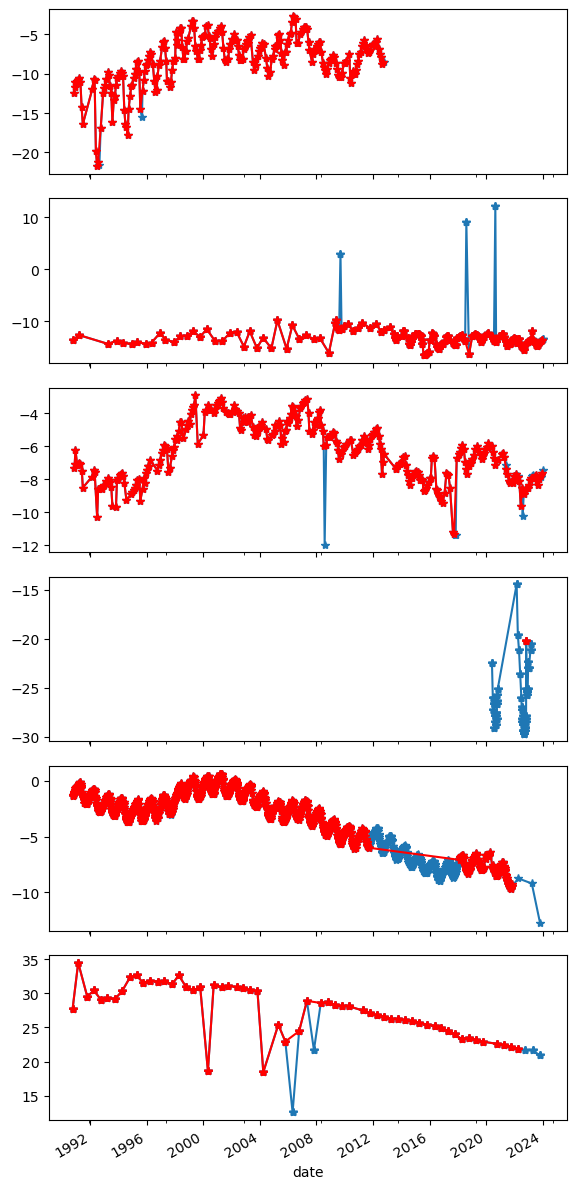

In [45]:
# review_stns = all_obs_out[~all_obs_out.site_code.isin(all_obs_chk_cln.site_code)].site_code.unique()

fig,axes=plt.subplots(len(review_stns),1, figsize=(6,12), sharex=True)
for i,n in enumerate(review_stns):
    ax = axes[i]
    all_obs_out[all_obs_out.site_code==n].plot(y='gwe',marker='*',ax=ax, legend=False)
    all_obs_chk_cln[all_obs_chk_cln.site_code==n].plot(y='gwe',marker='*',color='red',ax=ax, legend=False)
#     ax.set_title(all_obs[all_obs.site_code==n].site_code[0])
fig.tight_layout()

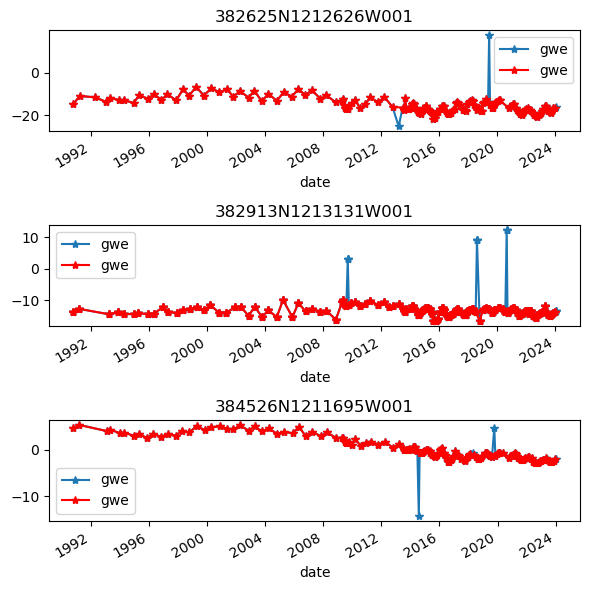

In [46]:
chk = 22825, 16614, 15343
fig,axes=plt.subplots(3,1, figsize=(6,6))
for i,n in enumerate(chk):
    ax = axes[i]
    all_obs_out[all_obs_out.node==n].plot(y='gwe',marker='*',ax=ax)
    all_obs_chk_cln[all_obs_chk_cln.node==n].plot(y='gwe',marker='*',color='red',ax=ax)
    ax.set_title(all_obs[all_obs.node==n].site_code[0])
fig.tight_layout()

In [336]:
# doesn't look right with seaborn with 30 yr frame, on a 10 year frame data looks more reasonable but still messy
# import seaborn as sns
# sns.relplot(all_obs, x='date',y='gwe', col='site_code', col_wrap=4, facet_kws={'sharey':False})

# Save files for model input

In [47]:
# save cleaned data to box data for all data
all_obs_out.to_csv(hob_dir+'/all_obs_grid_prepared.csv',index=True)
all_obs_chk_cln.to_csv(hob_dir+'/all_obs_grid_prepared_auto_QAQC.csv',index=True)

In [48]:
all_obs_out

,site_code,gwe,obs_nam,wlm_rpe,wlm_gse,wlm_acc_desc,latitude,longitude,well_type,well_use,...,top_prf_int,bot_prf_int,node,row,column,agency,dem_elev,dem_wlm_gse,interp_depth,avg_screen_depth
date,,,,,,,,,,,,,,,,,,,,,
1993-10-13,381963N1213552W001,1.338072,N20701.00001,9.110472,8.653272,Unknown,38.196300,-121.355200,Unknown,Irrigation,...,NaN,NaN,20701,91,1,DWR,8.557044,-0.096228,108.2040,102.79380
1993-03-22,381963N1213552W001,2.100072,N20701.00002,9.110472,8.653272,Unknown,38.196300,-121.355200,Unknown,Irrigation,...,NaN,NaN,20701,91,1,DWR,8.557044,-0.096228,108.2040,102.79380
1992-10-13,381963N1213552W001,-1.862328,N20701.00003,9.110472,8.653272,Unknown,38.196300,-121.355200,Unknown,Irrigation,...,NaN,NaN,20701,91,1,DWR,8.557044,-0.096228,108.2040,102.79380
1992-03-18,381963N1213552W001,-0.338328,N20701.00004,9.110472,8.653272,Unknown,38.196300,-121.355200,Unknown,Irrigation,...,NaN,NaN,20701,91,1,DWR,8.557044,-0.096228,108.2040,102.79380
1991-10-18,381963N1213552W001,-2.014728,N20701.00005,9.110472,8.653272,Unknown,38.196300,-121.355200,Unknown,Irrigation,...,NaN,NaN,20701,91,1,DWR,8.557044,-0.096228,108.2040,102.79380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-01,MW_Rooney 1,8.290454,N10746.00016,NaN,29.785000,NaN,38.479753,-121.201075,NaN,Irrigation,...,NaN,NaN,10746,47,166,UCD,29.964344,0.179344,113.0808,107.42676
2019-06-01,MW_Rooney 1,7.189657,N10746.00017,NaN,29.785000,NaN,38.479753,-121.201075,NaN,Irrigation,...,NaN,NaN,10746,47,166,UCD,29.964344,0.179344,113.0808,107.42676
2019-07-01,MW_Rooney 1,6.469304,N10746.00018,NaN,29.785000,NaN,38.479753,-121.201075,NaN,Irrigation,...,NaN,NaN,10746,47,166,UCD,29.964344,0.179344,113.0808,107.42676
